> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Combining imagery from a STAC API with labels from OSM

This notebook demonstrates a workflow where Sentinel-2 imagery from a STAC API is combined with annotations from OpenStreetMap to create a [GeoDataset](./sampling_training_data.ipynb) that can be used to [train a model](./train.ipynb).

For this example, our labels will be OSM labels for roads, our AOI will be the city of Paris, France, and the STAC API we will use is [Earth Search](https://www.element84.com/earth-search/).

## Install dependencies

In [1]:
!pip install osm2geojson==0.2.4 pystac_client==0.6.1 stackstac==0.4.3

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.3/994.3 kB 9.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 18.9 MB/s eta 0:00:00
  Created wheel for osm2geojson: filename=osm2geojson-0.2.4-py3-none-any.whl size=13835 sha256=2e57eb3029c85eb38abcc8000bd4f628ced337e56a4e96f8af687056bfa186ce
  Stored in directory: /root/.cache/pip/wheels/10/ba/2d/a69a5c63066d23cf432ff909fa3db5950bdf389a360b07c0d4
Successfully built osm2geojson
  Attempting uninstall: pystac
    Found existing installation: pystac 1.6.1
    Uninstalling pystac-1.6.1:
      Successfully uninstalled pystac-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that 

---

In [1]:
from rastervision.pipeline.file_system.utils import json_to_file, file_to_json
from rastervision.core.box import Box
from rastervision.core.data import (
    RasterioCRSTransformer, StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource
from rastervision.core.data.utils import (
    geom_to_feature, geoms_to_geojson, geojson_to_geoms,
    get_polygons_from_uris)

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

## Get labels from OSM via overpass API

In [2]:
import requests
import osm2geojson
from shapely.ops import unary_union

overpass_api_endpoint = 'https://overpass-api.de/api/interpreter'

def fetch_osm_geojson(query: str) -> dict:
    response = requests.get(f'{overpass_api_endpoint}?data=[out:xml][timeout:25];{query};out geom;')
    string = response.text.replace("\n","")
    geojson = osm2geojson.xml2geojson(string)
    return geojson

def get_city_boundary(country: str, city: str) -> Box:
    query = f"""
    area[name="{country}"][admin_level=2]->.country;
    area[name="{city}"][boundary=administrative](area.country);
    (
        way(area.country)[name="{city}"][boundary=administrative];
        relation(area.country)[name="{city}"][boundary=administrative];
    )
    """
    geojson = fetch_osm_geojson(query)
    geom = unary_union(list(geojson_to_geoms(geojson)))
    return geom

def get_city_bbox(country: str, city: str) -> Box:
    geom = get_city_boundary(country, city)
    city_bbox = Box.from_shapely(geom.envelope)
    return city_bbox

def get_city_features(country: str, city: str, query: str) -> dict:
    query_city = f"""
    area[name="{country}"][admin_level=2]->.country;
    area[name="{city}"][boundary=administrative](area.country)->.city;
    ({query})
    """
    geojson = fetch_osm_geojson(query_city)
    return geojson

We'll use road labels for Paris, France. In OSM, the super-category for all kinds of roads is "highway".

In [11]:
country = 'France'
city = 'Paris'
query_road = f'way(area.country)(area.city)["highway"];'

filename_features = f'roads_{city}.json'
filename_aoi = f'aoi_{city}.json'

In [5]:
geojson = get_city_features(country, city, query_road)
print(f'Features found: {len(geojson["features"])}')

print(f'Saving to {filename_features}')
json_to_file(geojson, filename_features)

aoi = get_city_boundary(country, city)
aoi_geojson = geoms_to_geojson([aoi])
print(f'Saving AOI to {filename_aoi}')
json_to_file(aoi_geojson, filename_aoi)

Features found: 66121
Saving to roads_Paris.json
Saving AOI to aoi_Paris.json


---

## Get Sentinel-2 imagery from STAC API as a `DataArray`

In [3]:
import pystac_client
import stackstac

We'll query the STAC API for items that intersect with the city's bounding box.

In [ ]:
# get city bounding box from OSM
bbox = get_city_bbox(country, city)
bbox_geometry = geom_to_feature(bbox.to_shapely())['geometry']
bbox, bbox_geometry

(Box(ymin=48.8155755, xmin=2.224122, ymax=48.902156, xmax=2.4697602),
 {'type': 'Polygon',
  'coordinates': (((2.224122, 48.8155755),
    (2.224122, 48.902156),
    (2.4697602, 48.902156),
    (2.4697602, 48.8155755),
    (2.224122, 48.8155755)),)})

Get items from the "Sentinel-2 L2A COGs" collection between 15 March 2023 and 7 April 2023, that intersect with the city's bounding box.

In [7]:
%%time

URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2023-03-15/2023-04-07",
    query={"eo:cloud_cover": {"lt": 5}},
).get_all_items()

stack = stackstac.stack(items)
stack

CPU times: user 44.5 ms, sys: 2.48 ms, total: 47 ms
Wall time: 840 ms


<xarray.DataArray 'stackstac-8d48b6f39d29198186505f437f606d9f' (time: 2,
                                                                band: 17,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(2, 17, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * time                          (time) datetime64[ns] 2023-03-26T10:57:26 2...
    id                            (time) <U24 'S2A_31UDQ_20230326_0_L2A' 'S2B...
  * band                          (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                             (x) float64 4e+05 4e+05 ... 5.098e+05
  * y                             (y) float64 5.5e+06 5.5e+06 ... 5.39e+06
    sentinel:sequence             <U1 '0'
    ...                            ...
    sentinel:grid_square          <U2 'DQ'
    title                         (band) <U31 'True color image' ... 'Scene C...
    common_name                   (band) object None None ... None None
    center_wavelength             (band) object None None 0.4439 ... None None
    full_width_half_max           (band) object None None 0.027 ... None None
    epsg                          int64 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(399960.0, 5390220.0, 509760.0...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 5500020.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [8]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

Subset the `DataArray` to a single timestamp and the 12 Sentinel-2 bands.

In [ ]:
data_array = stack
data_array = data_array.sel(band=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B08', 'B09', 'B11', 'B12'])
data_array = data_array.isel(time=-1)

In [9]:
raster_source_unnormalized = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    channel_order=list(range(len(data_array.band))),
    bbox=crs_transformer.map_to_pixel(Box(*bbox)).normalize(),
)
stats_tf = StatsTransformer.from_raster_sources([raster_source_unnormalized])

raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=list(range(len(data_array.band))),
    bbox=crs_transformer.map_to_pixel(Box(*bbox)).normalize(),
)
raster_source.shape

Analyzing chips: 0it [00:00, ?it/s]

(947, 1810, 12)

Visualize the full image (within the city's bounding box):

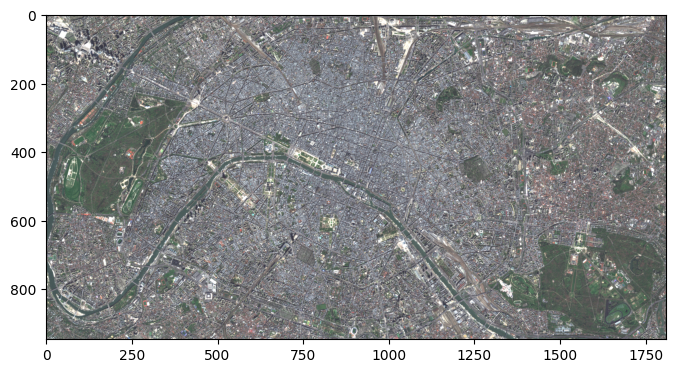

In [11]:
chip = raster_source[:, :, [3, 2, 1]]
chip.shape

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(chip)
plt.show()

## Read in the OSM labels as a `LabelSource`

In [12]:
from rastervision.core.data import (ClassConfig, 
                                    GeoJSONVectorSource, RasterizedSource, 
                                    Scene, SemanticSegmentationLabelSource)
from rastervision.core.data.vector_transformer import (BufferTransformer, ClassInferenceTransformer)
from rastervision.pytorch_learner import (SemanticSegmentationRandomWindowGeoDataset, 
                                          SemanticSegmentationSlidingWindowGeoDataset,
                                          SemanticSegmentationVisualizer)

labels_uri = filename_features

class_config = ClassConfig(
    names=['background', 'road'], 
    colors=['lightgray', 'black'],
    null_class='background')

In [17]:
road_class_id = class_config.get_class_id('road')

label_vector_source = GeoJSONVectorSource(
    labels_uri, 
    crs_transformer=crs_transformer, 
    ignore_crs_field=True,
    vector_transformers=[
        # assign class IDs to features in the GeoJSON
        ClassInferenceTransformer(
            # Here, this is redundant given we're using default_class_id=road_class_id,
            # but if we, for example, wanted to restrict to certain types of road,
            # or to have different classes from each type of road, we could do that
            # using class_id_to_filter.
            class_id_to_filter={
                road_class_id: ['in', 'tags', 'highway'],
            }, 
            default_class_id=road_class_id),
        # OSM represents roads as LineStrings, buffer them into polygons
        BufferTransformer('LineString', class_bufs={1: 0.5}),
    ]
)
label_raster_source = RasterizedSource(
    label_vector_source, 
    background_class_id=class_config.null_class_id,
    all_touched=True,
)
label_source = SemanticSegmentationLabelSource(label_raster_source, class_config)

Transforming to pixel coords:  19%|#9        | 12869/66121 [00:05<00:20, 2573.67it/s]

2023-06-02 19:39:17:rastervision.core.data.vector_source.vector_source: WARNING - Invalid geometries found in features in the GeoJSON.


Buffering LineStrings (if any):  53%|#####2    | 36448/68885 [00:05<00:04, 7289.56it/s]

## Create a `GeoDataset` for the scene

In [18]:
aoi_polygons = get_polygons_from_uris(filename_aoi, crs_transformer)
scene = Scene(
    id='test_scene', 
    raster_source=raster_source, 
    label_source=label_source, 
    aoi_polygons=aoi_polygons,
)
ds = SemanticSegmentationRandomWindowGeoDataset(
    scene=scene, size_lims=(200, 201), out_size=256)

### Visualize sample chips from the dataset

In [15]:
viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=dict(RGB=[3, 2, 1]))
viz.scale = 5

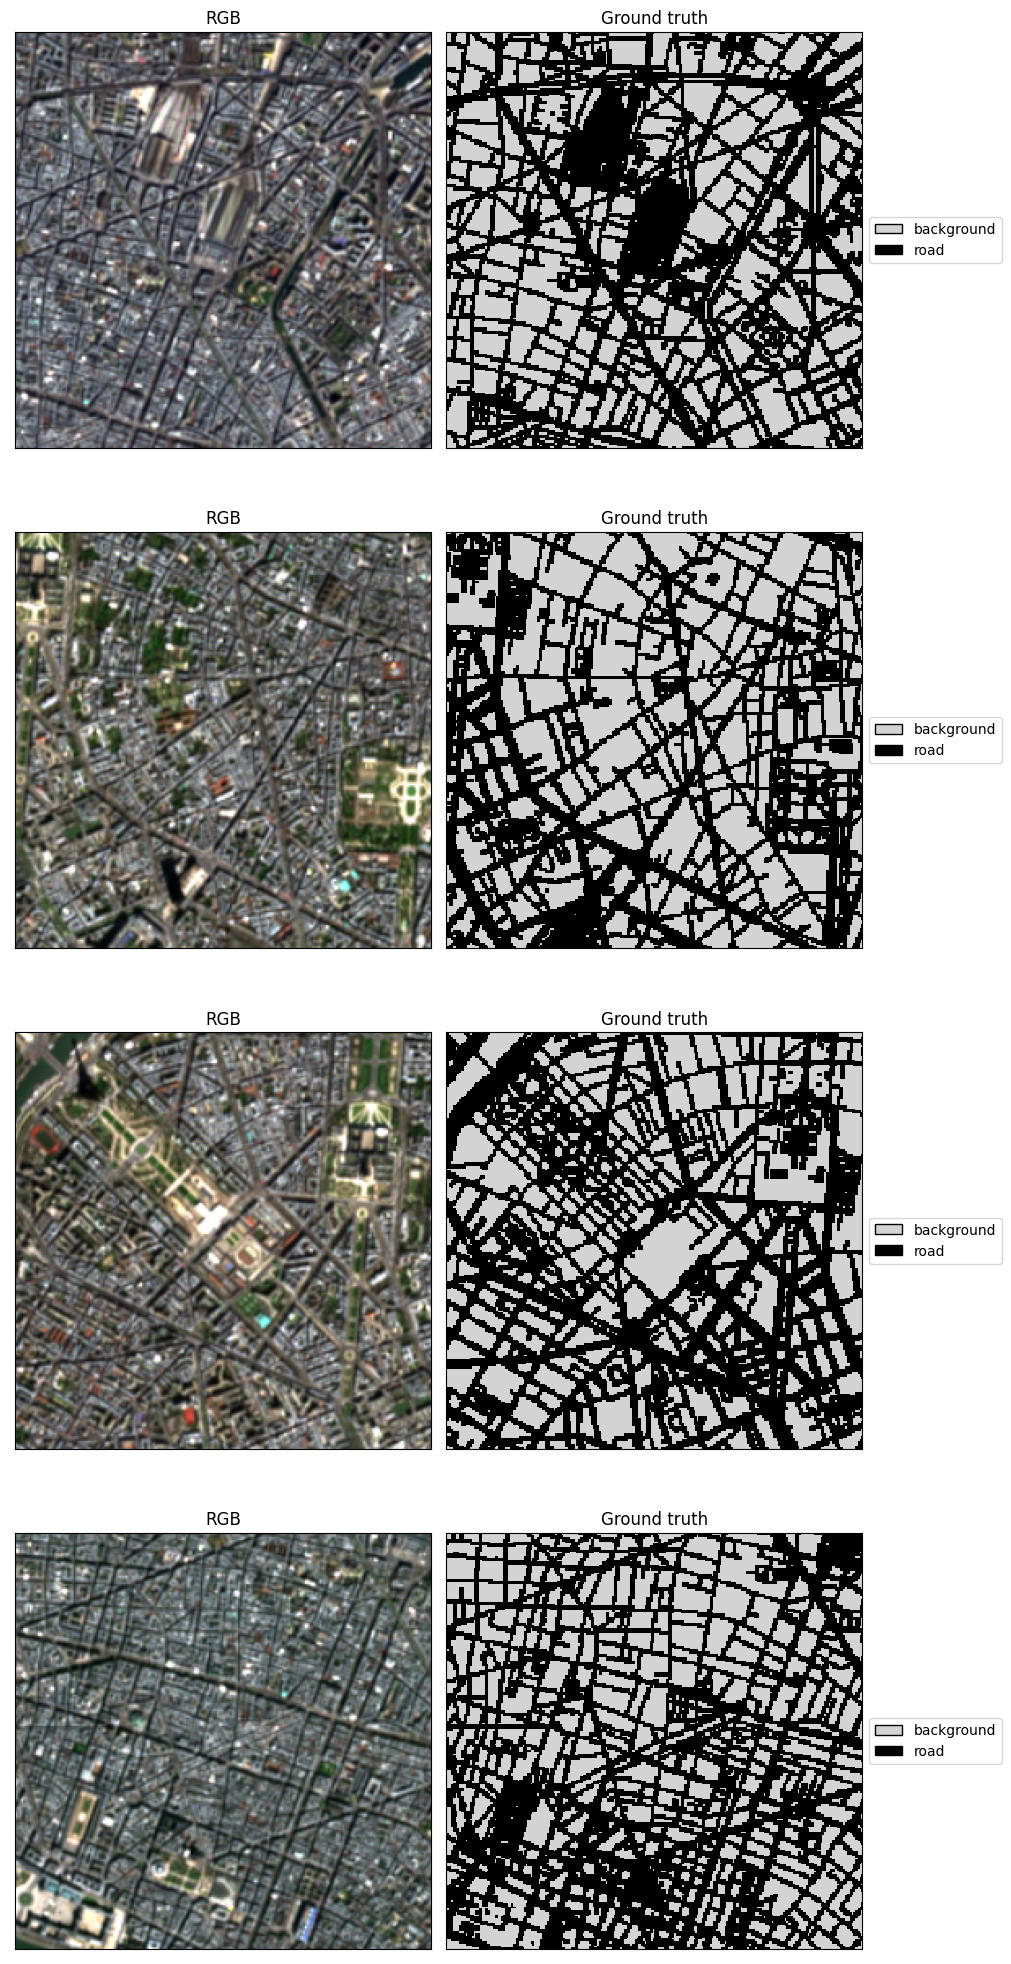

In [19]:
x, y = viz.get_batch(ds, 4)
viz.plot_batch(x, y, show=True)

## What next?

Take a look at the [training tutorial](./train.ipynb) to see how you can use this dataset for training!